In [1]:
import os
import json
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset #load_dataset from Huggingface
from scipy import stats
from scipy.stats import rankdata, spearmanr, pearsonr
import statsmodels.stats.proportion as smp

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LANG_DICT = {'arabic': 'ar', 
                 'english': 'en', 
                 'spanish': 'es',
                 'basque': 'eu',
                 'indonesian': 'id',
                 'burmese': 'my',
                 'russian': 'ru',
                 'telugu': 'te',
                 'chinese': 'zh',
                 'swahili': 'sw',
                 'hindi': 'hi'}

LANGUAGE = ['arabic', 'spanish', 'basque', 'hindi', 'indonesian', 'burmese', 'russian', 'telugu', 'chinese', 'swahili']
INPUT_FIELD = ['input_sentence_1', 'input_sentence_2', 'input_sentence_3', 'input_sentence_4', 'sentence_quiz1', 'sentence_quiz2']

In [3]:
def get_accuracy_outputs(lang, dataset='xstorycloze', model='Llama3.1', mode='normalized', shot=0):
    model_dict = {'Llama3.1': 'meta-llama__Llama-3.1-8B'}
    lang_code = LANG_DICT[lang]
    model_code = model_dict[model]
    if dataset == 'xstorycloze':
        hf = load_dataset("juletxara/xstory_cloze", lang_code)
        answer_right_ending = hf['eval']['answer_right_ending']
        answer = []
        for i in range(len(answer_right_ending)):
            answer.append(answer_right_ending[i])
    
    if mode == 'normalized':
        accuracy_data_path = f'../../accuracy_outputs/{model}/{dataset}_normalized_{shot}shot/{lang_code}/{model_code}/'
    else:
        accuracy_data_path = f'../../accuracy_outputs/{model}/{dataset}_unnormalized_{shot}shot/{lang_code}/{model_code}/'
    # Find the .jsonl file in the directory
    jsonl_file = [f for f in os.listdir(accuracy_data_path) if f.endswith('.jsonl')][0]
    file_path = os.path.join(accuracy_data_path, jsonl_file)
    # Read the jsonl file line by line
    accuracy_results = []
    with open(file_path, 'r') as f:
        for line in f:
            accuracy_results.append(json.loads(line))

    resps = [item['resps'] for item in accuracy_results]
    accuracy = [item['acc'] for item in accuracy_results]
    score_diff = []
    for i in range(len(answer)):
        if answer[i]==1:
            score_diff.append(float(resps[i][0][0][0]) - float(resps[i][1][0][0]))
        if answer[i]==2:
            score_diff.append(float(resps[i][1][0][0]) - float(resps[i][0][0][0]))
    return score_diff, accuracy

In [4]:
def compute_confusion_matrix(correct_eng, incorrect_eng, correct_lang, incorrect_lang):
    TP = len(set(correct_eng) & set(correct_lang))
    FN = len(set(incorrect_eng) & set(correct_lang))
    FP = len(set(correct_eng) & set(incorrect_lang))
    TN = len(set(incorrect_eng) & set(incorrect_lang))
    
    return np.array([[TP, FN], [FP, TN]])

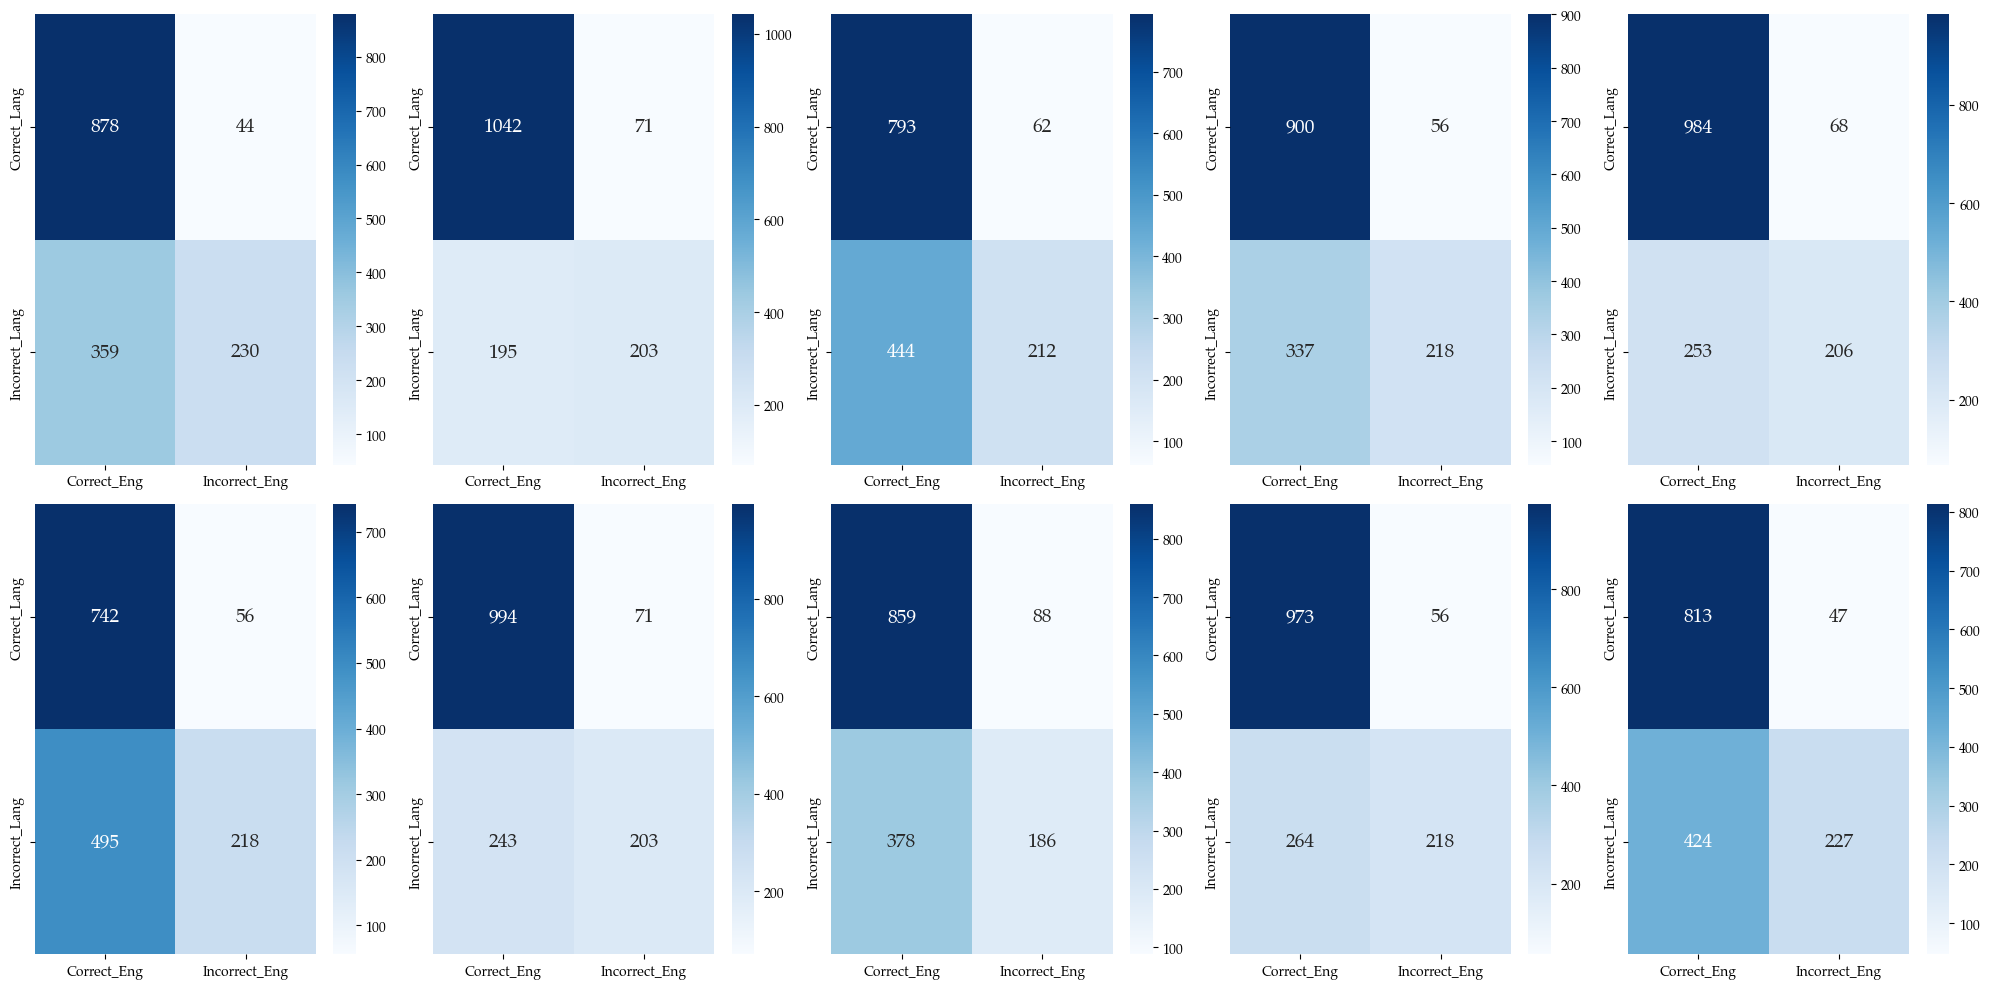

In [5]:
acc_dict = defaultdict(dict)
score_diff_dict = defaultdict(dict)
plt.rcParams["savefig.format"] = 'pdf'
plt.rcParams['font.family'] = 'Palatino'

conf_matrices = defaultdict(dict)

score_diff_dict['english'], acc_dict['english'] = get_accuracy_outputs('english', 'xstorycloze', 'Llama3.1', mode='unnormalized', shot=5)

for lang in LANGUAGE:
    score_diff_dict[lang],acc_dict[lang]  = get_accuracy_outputs(lang, 'xstorycloze', 'Llama3.1', mode='unnormalized', shot=5)
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==0]
       
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]

    # Example language data (Replace with actual lists)
    conf_matrices[lang] = compute_confusion_matrix(correct_id_eng, incorrect_id_eng, correct_id_lang, incorrect_id_lang)
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))

# Plot multiple confusion matrices
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns

for ax, (lang, matrix) in zip(axes.flat, conf_matrices.items()):

#for lang, matrix in conf_matrices.items():    
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Correct_Eng", "Incorrect_Eng"], 
                yticklabels=["Correct_Lang", "Incorrect_Lang"], annot_kws={"size": 14}, ax=ax)
    #plt.set_title(lang)

    plt.tight_layout()
plt.show()
#plt.savefig(fname='../../../../Images_DALI/cohort_level_analysis_illustrated.pdf')   


In [6]:
def plot_DALI(dataset, lang, model, mode):
    if mode == 'DALI':
        DAS_path = f'../../alignment_outputs/{model}/{dataset}_dali/BAS_{lang}_lasttoken.json'
    if mode == 'DALIStrong':
        DAS_path = f'../../alignment_outputs/{model}/{dataset}_dali_strong/DALI_{lang}_lasttoken.json'

    if mode == 'MEXAFlores':
        flores_dict = {'arabic': 'arb_Arab', 
                       'spanish': 'spa_Latn',
                        'basque': 'eus_Latn',
                         'hindi': 'hin_Deva',
                          'indonesian': 'ind_Latn',
                           'burmese': 'mya_Mymr',
                            'russian': 'rus_Cyrl',
                             'telugu': 'tel_Telu',
                              'chinese': 'zho_Hans',
                               'swahili': 'swh_Latn'}
        
        lang_code = flores_dict[lang]

        DAS_path = f'../../alignment_outputs/{model}/flores_mexa/{lang_code}.json'
    if mode == 'MEXATask':
        DAS_path = f'../../alignment_outputs/{model}/{dataset}_mexa/{lang}.json'
    with open(DAS_path) as f:
        lang_DAS = json.load(f)
    return lang_DAS

In [7]:
def load_translation_agg(dataset, model, field):
    if dataset == 'flores':
        entoxxpath = f'../../translation_outputs/{model}/{dataset}_100/sentence/entoxx_{model}_{dataset}_COMET.json'
        xxtoenpath = f'../../translation_outputs/{model}/{dataset}_100/sentence/xxtoen_{model}_{dataset}_COMET.json'
        list_of_languages = ['modern standard arabic', 'spanish', 'basque', 'hindi', 'indonesian', 'burmese', 'russian', 'telugu', 'simplified chinese', 'swahili']
        lang_key = {'modern standard arabic': 'arabic', 'spanish': 'spanish', 'basque': 'basque', 'hindi': 'hindi', 'indonesian': 'indonesian', 'burmese': 'burmese', 'russian': 'russian', 'telugu': 'telugu', 'simplified chinese': 'chinese', 'swahili': 'swahili'}

        with open(entoxxpath) as f:
            entoxx_COMET = json.load(f)
    
        with open(xxtoenpath) as f:
            xxtoen_COMET = json.load(f)
        
        entoxx_COMET_filtered = {}
        xxtoen_COMET_filtered = {}
        for k,v in entoxx_COMET.items():
            
            if k in list_of_languages:
                entoxx_COMET_filtered[lang_key[k]] = v[0]
        for k,v in xxtoen_COMET.items():
            if k in list_of_languages:
                xxtoen_COMET_filtered[lang_key[k]] = v[0]

    if dataset == 'xstorycloze':
        entoxxpath = f'../../translation_outputs/{model}/{dataset}/{field}/entoxx_{model}_{dataset}_COMET.json'
        xxtoenpath = f'../../translation_outputs/{model}/{dataset}/{field}/xxtoen_{model}_{dataset}_COMET.json'

        with open(entoxxpath) as f:
            entoxx_COMET = json.load(f)
        with open(xxtoenpath) as f:
            xxtoen_COMET = json.load(f)
        entoxx_COMET_filtered = {}
        xxtoen_COMET_filtered = {}

        for k,v in entoxx_COMET.items():
            entoxx_COMET_filtered[k] = v[0]
        for k,v in xxtoen_COMET.items():
            xxtoen_COMET_filtered[k] = v[0]           
    return entoxx_COMET_filtered, xxtoen_COMET_filtered


In [8]:
# Calculate accuracies and get DAS scores for each language
def plot_alignment_by_layers(mode):
    accuracies = {}
    max_das_scores = {}
    mean_das_scores = {}
    all_das_avgs = {}

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.rcParams['font.family'] = 'Palatino'


    for lang in LANGUAGE:
        # Calculate accuracy
        accuracies[lang] = (sum(acc_dict[lang])/len(acc_dict[lang])) 
        # Get DAS data for this language
        lang_DAS = plot_DALI('xstorycloze', lang, 'Llama3.1', mode)
        
        if mode == 'DALI' or mode == 'DALIStrong':
            lang_DAS = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                        for outer_k, inner_v in lang_DAS.items()}
            layer_avgs = []
            for layer in range(32):
                layer_scores = [lang_DAS[sample][layer] for sample in lang_DAS.keys()]
                layer_avgs.append(np.mean(layer_scores))

            all_das_avgs[lang] = layer_avgs
            max_das_scores[lang] = np.max(all_das_avgs[lang])
            mean_das_scores[lang] = np.mean(all_das_avgs[lang])
            ax.plot(range(32), layer_avgs, 
                label=f'{lang.capitalize()}', 
                marker='o', markersize=2)


            
        else: 
            lang_DAS = {int(k): v for k,v in lang_DAS.items()}
            layer_avgs = []
            for layer in range(32):
                layer_avgs.append(np.mean(lang_DAS[layer]))      
            all_das_avgs[lang] = layer_avgs
            max_das_scores[lang] = np.max(all_das_avgs[lang])
            mean_das_scores[lang] = np.mean(all_das_avgs[lang])
            

            ax.plot(range(32), layer_avgs, 
                label=f'{lang.capitalize()}', 
                marker='o', markersize=2)

    ax.set_xlabel('Layer')
    ax.tick_params(axis='both',labelsize=14)
    ax.set_ylabel(f'{mode}')
    #ax.set_title('DALI Scores Across Layers (story completion)')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(0,1)
    #plt.tight_layout()
    #plt.show()
    return accuracies, max_das_scores, mean_das_scores

In [9]:
entoxx_flores_agg, xxtoen_flores_agg = load_translation_agg('flores', 'Llama3.1', field=None)
entoxx_input1, xxtoen_input1 = load_translation_agg('xstorycloze', 'Llama3.1', field='input_sentence_1')
entoxx_input2, xxtoen_input2 = load_translation_agg('xstorycloze', 'Llama3.1', field='input_sentence_2')
entoxx_input3, xxtoen_input3 = load_translation_agg('xstorycloze', 'Llama3.1', field='input_sentence_3')
entoxx_input4, xxtoen_input4 = load_translation_agg('xstorycloze', 'Llama3.1', field='input_sentence_4')
entoxx_end1, xxtoen_end1 = load_translation_agg('xstorycloze', 'Llama3.1', field='sentence_quiz1')
entoxx_end2, xxtoen_end2 = load_translation_agg('xstorycloze', 'Llama3.1', field='sentence_quiz2')

entoxx_premise_agg = defaultdict()
xxtoen_premise_agg = defaultdict()


entoxx_dataset_agg = {}
xxtoen_dataset_agg = {}

for k in entoxx_input1.keys():
    entoxx_dataset_agg[k] = np.mean([entoxx_input1[k], entoxx_input2[k], entoxx_input3[k], entoxx_input4[k], entoxx_end1[k], entoxx_end2[k]])
    xxtoen_dataset_agg[k] = np.mean([xxtoen_input1[k], xxtoen_input2[k], xxtoen_input3[k], xxtoen_input4[k], xxtoen_end1[k], xxtoen_end2[k]])

for k in entoxx_input1.keys():
    entoxx_premise_agg[k] = np.mean([entoxx_input1[k], entoxx_input2[k], entoxx_input3[k], entoxx_input4[k]])
    xxtoen_premise_agg[k] = np.mean([xxtoen_input1[k], xxtoen_input2[k], xxtoen_input3[k], xxtoen_input4[k]])

In [10]:
def load_translation_sample(dataset, model, field):
    entoxxpath = f'../../translation_outputs/{model}/{dataset}/{field}/entoxx_{model}_{dataset}_COMET_sample.json'
    xxtoenpath = f'../../translation_outputs/{model}/{dataset}/{field}/xxtoen_{model}_{dataset}_COMET_sample.json'

    with open(entoxxpath) as f:
        entoxx_COMET_sample = json.load(f)
    with open(xxtoenpath) as f:
        xxtoen_COMET_sample = json.load(f)

    return entoxx_COMET_sample, xxtoen_COMET_sample

In [ ]:
def plot_ranked_correlation(entoxx_dataset_agg, 
                            xxtoen_dataset_agg, 
                            entoxx_flores_agg, 
                            xxtoen_flores_agg,
                            entoxx_premise_agg,
                            xxtoen_premise_agg,
                            accuracies,
                            dali,
                            dali_strong,
                            mexa_flores,
                            mexa_dataset,
                            mode = "translation-accuracy"):
    
    accuracies_rank = rankdata([accuracies[lang] for lang in LANGUAGE])
    entoxx_flores_rank = rankdata([entoxx_flores_agg[lang] for lang in LANGUAGE])
    xxtoen_flores_rank = rankdata([xxtoen_flores_agg[lang] for lang in LANGUAGE])
    entoxx_dataset_rank = rankdata([entoxx_dataset_agg[lang] for lang in LANGUAGE])
    xxtoen_dataset_rank = rankdata([xxtoen_dataset_agg[lang] for lang in LANGUAGE])

    entoxx_premise_rank = rankdata([entoxx_premise_agg[lang] for lang in LANGUAGE])
    xxtoen_premise_rank = rankdata([xxtoen_premise_agg[lang] for lang in LANGUAGE])



    dali_rank = rankdata([dali[lang] for lang in LANGUAGE])
    dali_strong_rank = rankdata([dali_strong[lang] for lang in LANGUAGE])
    mexa_flores_rank = rankdata([mexa_flores[lang] for lang in LANGUAGE])
    mexa_dataset_rank = rankdata([mexa_dataset[lang] for lang in LANGUAGE])

    if mode == "translation-accuracy":
        fig, axes = plt.subplots(2, 2, figsize=(10, 6))
        # Calculate Pearson correlation coefficient
        corr_entoxx_flores_acc, _ = spearmanr(entoxx_flores_rank, accuracies_rank)
        corr_xxtoen_flores_acc, _ = spearmanr(xxtoen_flores_rank, accuracies_rank)
        corr_entoxx_dataset_acc, _ = spearmanr(entoxx_dataset_rank, accuracies_rank)
        corr_xxtoen_dataset_acc, _ = spearmanr(xxtoen_dataset_rank, accuracies_rank)

        slope_entoxx_flores_acc, b_entoxx_flores_acc = np.polyfit(entoxx_dataset_rank, accuracies_rank, 1)
        slope_xxtoen_flores_acc, b_xxtoen_flores_acc = np.polyfit(xxtoen_dataset_rank, accuracies_rank, 1)
        slope_entoxx_dataset_acc, b_entoxx_dataset_acc = np.polyfit(entoxx_dataset_rank, accuracies_rank, 1)
        slope_xxtoen_dataset_acc, b_xxtoen_dataset_acc = np.polyfit(xxtoen_dataset_rank, accuracies_rank, 1)

        axes[0][0].scatter(entoxx_flores_rank, accuracies_rank, alpha=0.7, color='blue')
        axes[0][0].plot(entoxx_flores_rank, np.array(entoxx_flores_rank) * slope_entoxx_flores_acc + b_entoxx_flores_acc, color='red', label=f'Linear fit: y={slope_entoxx_flores_acc:.2f}x+{b_entoxx_flores_acc:.2f}')
        axes[0][0].text(min(entoxx_flores_rank)+1, max(accuracies_rank)-1., f'Spearman r: {corr_entoxx_flores_acc:.2f}', fontsize=12, color='red')
        axes[0][0].set_xlabel('COMET Flores (En->XX)')
        axes[0][0].set_ylabel('Accuracy')
        axes[0][0].set_title(f'En->XX Flores COMET vs Accuracy')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[0][0].grid(True)

        axes[0][1].scatter(xxtoen_flores_rank, accuracies_rank, alpha=0.7, color='teal')
        axes[0][1].plot(xxtoen_flores_rank, np.array(xxtoen_flores_rank) * slope_xxtoen_flores_acc + b_xxtoen_flores_acc, color='red', label=f'Linear fit: y={slope_xxtoen_flores_acc:.2f}x+{b_xxtoen_flores_acc:.2f}')
        axes[0][1].text(min(xxtoen_flores_rank)+1, max(accuracies_rank)-1, f'Spearman r: {corr_xxtoen_flores_acc:.2f}', fontsize=12, color='red')
        axes[0][1].set_xlabel('COMET Flores (XX->En)')
        axes[0][1].set_ylabel('Accuracy')
        axes[0][1].set_title(f'XX->En Flores COMET vs Accuracy')
        #axes[0][1].set_xlim(0,1)
        #axes[0][1].set_ylim(0,1)
        #axes[0].legend()
        axes[0][1].grid(True)

        axes[1][0].scatter(entoxx_dataset_rank, accuracies_rank, alpha=0.7, color='brown')
        axes[1][0].plot(entoxx_dataset_rank, np.array(entoxx_dataset_rank) * slope_entoxx_dataset_acc + b_entoxx_dataset_acc, color='red', label=f'Linear fit: y={slope_entoxx_dataset_acc:.2f}x+{b_entoxx_dataset_acc:.2f}')
        axes[1][0].text(min(entoxx_dataset_rank)+1, max(accuracies_rank)-1, f'Spearman r: {corr_entoxx_dataset_acc:.2f}', fontsize=12, color='red')
        axes[1][0].set_xlabel('COMET Dataset (En->XX)')
        axes[1][0].set_ylabel('Accuracy')
        axes[1][0].set_title(f'En->XX Dataset COMET vs Accuracy')
        #axes[1][0].set_xlim(0,1)
        #axes[1][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][0].grid(True)

        axes[1][1].scatter(xxtoen_dataset_rank, accuracies_rank, alpha=0.7, color='green')
        axes[1][1].plot(xxtoen_dataset_rank, np.array(xxtoen_dataset_rank) * slope_xxtoen_dataset_acc + b_xxtoen_dataset_acc, color='red', label=f'Linear fit: y={slope_xxtoen_dataset_acc:.2f}x+{b_xxtoen_dataset_acc:.2f}')
        axes[1][1].text(min(xxtoen_dataset_rank)+1, max(accuracies_rank)-1, f'Spearman r: {corr_xxtoen_dataset_acc:.2f}', fontsize=12, color='red')
        axes[1][1].set_xlabel('COMET Dataset (XX->En)')
        axes[1][1].set_ylabel('Accuracy')
        axes[1][1].set_title(f'XX->En Dataset COMET vs Accuracy')
        #axes[1][1].set_xlim(0,1)
        #axes[1][1].set_ylim(0,1)
        #axes[0].legend()
        axes[1][1].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle('Rank Correlation: Translation Quality vs Accuracy in Xstorycloze')
        
        plt.savefig(fname='../../../../Images_DALI/xstorycloze_plots/rankcorrel_translationquality_vs_accuracy')
        plt.show()

    if mode == "alignment-translation":
        fig, axes = plt.subplots(1, 2, figsize=(10, 6))
        # Calculate Pearson correlation coefficient
        
        corr_entoxx_task_mexa, _ = spearmanr(mexa_dataset_rank, entoxx_premise_rank)
        corr_xxtoen_task_mexa, _ = spearmanr(mexa_dataset_rank, xxtoen_premise_rank)

        slope_entoxx_task_mexa, b_entoxx_task_mexa = np.polyfit(mexa_dataset_rank, entoxx_premise_rank, 1)
        slope_xxtoen_task_mexa, b_xxtoen_task_mexa = np.polyfit(mexa_dataset_rank, xxtoen_premise_rank, 1)

        axes[0].scatter(mexa_dataset_rank, entoxx_premise_rank, alpha=0.7, color='blue')
        axes[0].plot(entoxx_premise_rank, np.array(entoxx_premise_rank) * slope_entoxx_task_mexa + b_entoxx_task_mexa, color='red', label=f'Linear fit: y={slope_entoxx_task_mexa:.2f}x+{b_entoxx_task_mexa:.2f}')
        axes[0].text(min(mexa_dataset_rank)+1, max(entoxx_premise_rank)-1., f'Spearman r: {corr_entoxx_task_mexa:.2f}', fontsize=12, color='red')
        axes[0].set_xlabel('MEXA Task')
        axes[0].set_ylabel('En->XX Premise COMET')
        axes[0].set_title(f'MEXA Task vs En->XX Premise')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[0].grid(True)

        axes[1].scatter(mexa_dataset_rank, xxtoen_premise_rank, alpha=0.7, color='blue')
        axes[1].plot(xxtoen_premise_rank, np.array(xxtoen_premise_rank) * slope_xxtoen_task_mexa + b_xxtoen_task_mexa, color='red', label=f'Linear fit: y={slope_xxtoen_task_mexa:.2f}x+{b_xxtoen_task_mexa:.2f}')
        axes[1].text(min(mexa_dataset_rank)+1, max(xxtoen_premise_rank)-1., f'Spearman r: {corr_xxtoen_task_mexa:.2f}', fontsize=12, color='red')
        axes[1].set_xlabel('MEXA Task')
        axes[1].set_ylabel('XX->En Premise COMET')
        axes[1].set_title(f'MEXA Task vs XX->En Premise')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle('Rank Correlation: MEXA (Task) vs Translation Quality in Xstorycloze')
        
        plt.savefig(fname='../../../../Images_DALI/xstorycloze_plots/rankcorrel_mexa_vs_translationquality')
        plt.show()

    if mode == "alignment-accuracy":
        fig, axes = plt.subplots(2, 2, figsize=(10, 6))
        # Calculate Pearson correlation coefficient
        corr_dali_acc, _ = spearmanr(dali_rank, accuracies_rank)
        corr_dalistrong_acc, _ = spearmanr(dali_strong_rank, accuracies_rank)
        corr_mexaflores_acc, _ = spearmanr(mexa_flores_rank, accuracies_rank)
        corr_mexadataset_acc, _ = spearmanr(mexa_dataset_rank, accuracies_rank)

        slope_dali_acc, b_dali_acc = np.polyfit(dali_rank, accuracies_rank, 1)
        slope_dalistrong_acc, b_dalistrong_acc = np.polyfit(dali_strong_rank, accuracies_rank, 1)
        slope_mexaflores_acc, b_mexaflores_acc = np.polyfit(mexa_flores_rank, accuracies_rank, 1)
        slope_mexadataset_acc, b_mexadataset_acc = np.polyfit(mexa_dataset_rank, accuracies_rank, 1)

        axes[0][0].scatter(dali_rank, accuracies_rank, alpha=0.7, color='blue')
        axes[0][0].plot(dali_rank, np.array(dali_rank) * slope_dali_acc + b_dali_acc, color='red', label=f'Linear fit: y={slope_dali_acc:.2f}x+{b_dali_acc:.2f}')
        axes[0][0].text(min(dali_rank)+1, max(accuracies_rank)-1., f'Spearman r: {corr_dali_acc:.2f}', fontsize=12, color='red')
        axes[0][0].set_xlabel('DALI (Maxpool)')
        axes[0][0].set_ylabel('Accuracy')
        axes[0][0].set_title(f'DALI vs Accuracy')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[0][0].grid(True)

        axes[0][1].scatter(dali_strong_rank, accuracies_rank, alpha=0.7, color='blue')
        axes[0][1].plot(dali_strong_rank, np.array(dali_strong_rank) * slope_dalistrong_acc + b_dalistrong_acc, color='red', label=f'Linear fit: y={slope_dalistrong_acc:.2f}x+{b_dalistrong_acc:.2f}')
        axes[0][1].text(min(dali_strong_rank)+1, max(accuracies_rank)-1., f'Spearman r: {corr_dalistrong_acc:.2f}', fontsize=12, color='red')
        axes[0][1].set_xlabel('DALIStrong (Maxpool)')
        axes[0][1].set_ylabel('Accuracy')
        axes[0][1].set_title(f'DALIStrong vs Accuracy')
        #axes[0][1].set_xlim(0,1)
        #axes[0][1].set_ylim(0,1)
        #axes[0].legend()
        axes[0][1].grid(True)

        axes[1][0].scatter(mexa_flores_rank, accuracies_rank, alpha=0.7, color='blue')
        axes[1][0].plot(mexa_flores_rank, np.array(mexa_flores_rank) * slope_mexaflores_acc + b_mexaflores_acc, color='red', label=f'Linear fit: y={slope_mexaflores_acc:.2f}x+{b_mexaflores_acc:.2f}')
        axes[1][0].text(min(mexa_flores_rank)+1, max(accuracies_rank)-1., f'Spearman r: {corr_mexaflores_acc:.2f}', fontsize=12, color='red')
        axes[1][0].set_xlabel('MEXA Flores (Maxpool)')
        axes[1][0].set_ylabel('Accuracy')
        axes[1][0].set_title(f'MEXA Flores vs Accuracy')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][0].grid(True)

        axes[1][1].scatter(mexa_dataset_rank, accuracies_rank, alpha=0.7, color='blue')
        axes[1][1].plot(mexa_dataset_rank, np.array(mexa_dataset_rank) * slope_mexadataset_acc + b_mexadataset_acc, color='red', label=f'Linear fit: y={slope_mexadataset_acc:.2f}x+{b_mexadataset_acc:.2f}')
        axes[1][1].text(min(mexa_dataset_rank)+1, max(accuracies_rank)-1., f'Spearman r: {corr_mexadataset_acc:.2f}', fontsize=12, color='red')
        axes[1][1].set_xlabel('MEXA Dataset (Maxpool)')
        axes[1][1].set_ylabel('Accuracy')
        axes[1][1].set_title(f'MEXA Dataset vs Accuracy')
        #axes[0][0].set_xlim(0,1)
        #axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][1].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle('Rank Correlation: Cross-Lingual Alignment vs Accuracy in Xstorycloze')
        
        plt.savefig(fname='../../../../Images_DALI/xstorycloze_plots/rankcorrel_alignment_vs_accuracy.pdf')
        plt.show()



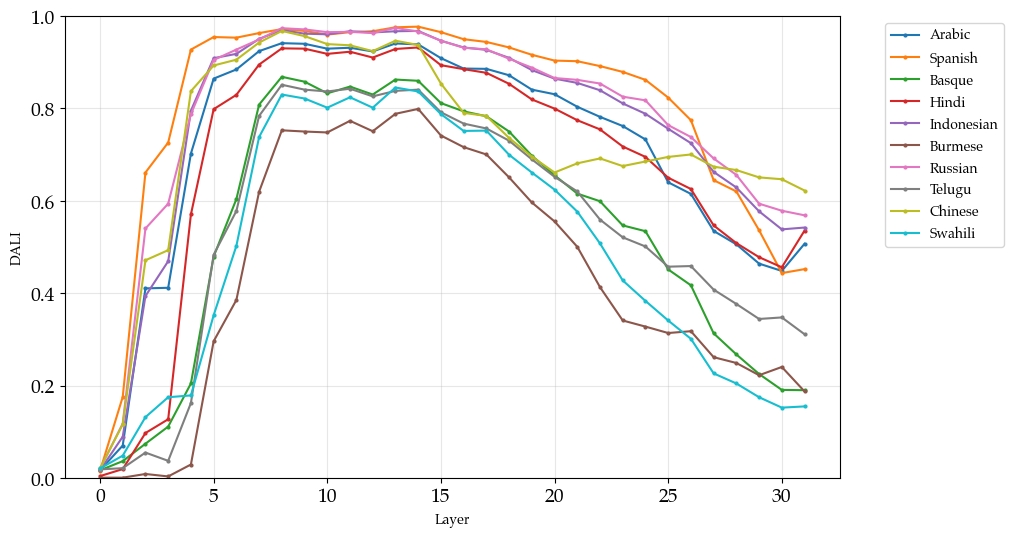

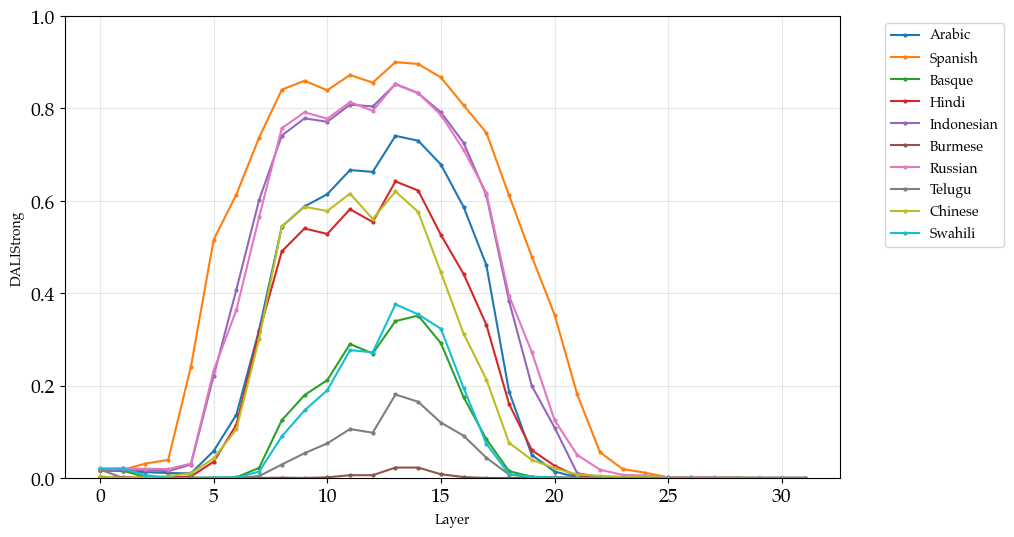

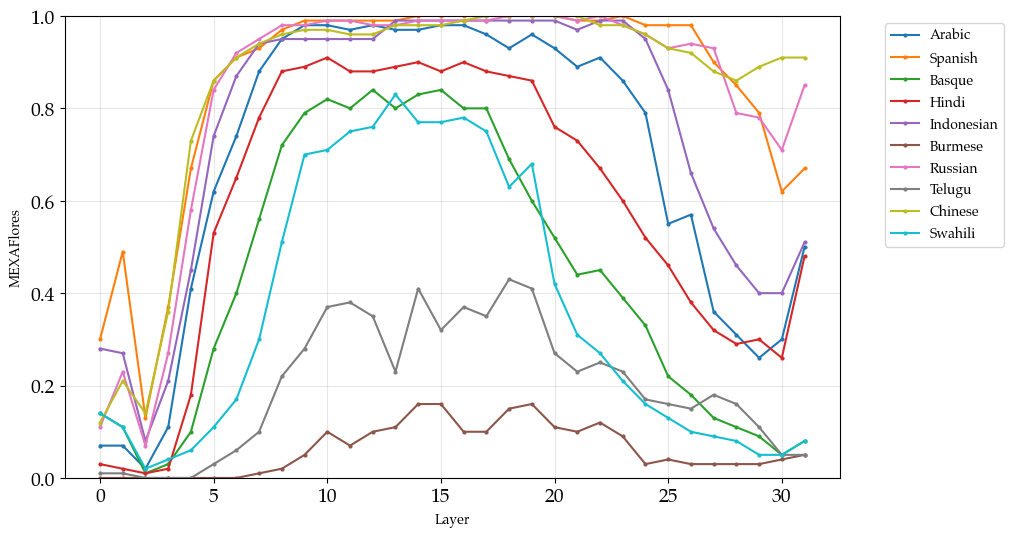

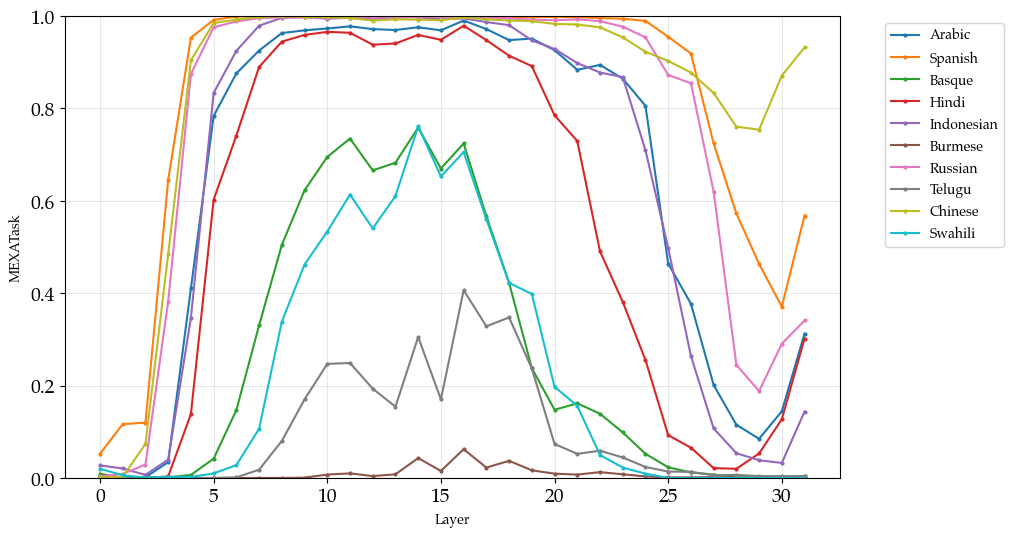

In [11]:
accuracies, max_pooled_dali_scores, mean_pooled_dali_scores = plot_alignment_by_layers('DALI')
accuracies, max_pooled_dalistrong_scores, mean_pooled_dalistrong_scores = plot_alignment_by_layers('DALIStrong')
accuracies, max_pooled_mexaflores_scores, mean_pooled_mexaflores_scores = plot_alignment_by_layers('MEXAFlores')
accuracies, max_pooled_mexadataset_scores,mean_pooled_mexadataset_scores = plot_alignment_by_layers('MEXATask')

In [ ]:
plot_ranked_correlation(entoxx_dataset_agg, 
                        xxtoen_dataset_agg, 
                        entoxx_flores_agg, 
                        xxtoen_flores_agg, 
                        entoxx_premise_agg,
                        xxtoen_premise_agg,
                        accuracies, 
                        mean_pooled_dali_scores, 
                        mean_pooled_dalistrong_scores,
                        mean_pooled_mexaflores_scores,
                        mean_pooled_mexadataset_scores,
                        mode='alignment-translation')

In [ ]:
def plot_pearson_correlation(entoxx_dataset_agg, 
                            xxtoen_dataset_agg, 
                            entoxx_flores_agg, 
                            xxtoen_flores_agg,
                            entoxx_premise_agg,
                            xxtoen_premise_agg,
                            accuracies,
                            dali,
                            dali_strong,
                            mexa_flores,
                            mexa_dataset,
                            mode = "translation-accuracy"):
    
    accuracies = [accuracies[lang] for lang in LANGUAGE]
    entoxx_flores = [entoxx_flores_agg[lang] for lang in LANGUAGE]
    xxtoen_flores = [xxtoen_flores_agg[lang] for lang in LANGUAGE]
    entoxx_dataset = [entoxx_dataset_agg[lang] for lang in LANGUAGE]
    xxtoen_dataset = [xxtoen_dataset_agg[lang] for lang in LANGUAGE]

    entoxx_premise = [entoxx_premise_agg[lang] for lang in LANGUAGE]
    xxtoen_premise = [xxtoen_premise_agg[lang] for lang in LANGUAGE]



    dali = [dali[lang] for lang in LANGUAGE]
    dali_strong = [dali_strong[lang] for lang in LANGUAGE]
    mexa_flores = [mexa_flores[lang] for lang in LANGUAGE]
    mexa_dataset = [mexa_dataset[lang] for lang in LANGUAGE]
    

    if mode == "translation-accuracy":
        fig, axes = plt.subplots(2, 2, figsize=(10, 6))    
        # Calculate Pearson correlation coefficient
        corr_entoxx_flores_acc, _ = pearsonr(entoxx_flores, accuracies)
        corr_xxtoen_flores_acc, _ = pearsonr(xxtoen_flores, accuracies)
        corr_entoxx_dataset_acc, _ = pearsonr(entoxx_dataset, accuracies)
        corr_xxtoen_dataset_acc, _ = pearsonr(xxtoen_dataset, accuracies)

        slope_entoxx_flores_acc, b_entoxx_flores_acc = np.polyfit(entoxx_dataset, accuracies, 1)
        slope_xxtoen_flores_acc, b_xxtoen_flores_acc = np.polyfit(xxtoen_dataset, accuracies, 1)
        slope_entoxx_dataset_acc, b_entoxx_dataset_acc = np.polyfit(entoxx_dataset, accuracies, 1)
        slope_xxtoen_dataset_acc, b_xxtoen_dataset_acc = np.polyfit(xxtoen_dataset, accuracies, 1)
        

        axes[0][0].scatter(entoxx_flores, accuracies, alpha=0.7, color='blue')
        axes[0][0].plot(entoxx_flores, np.array(entoxx_flores) * slope_entoxx_flores_acc + b_entoxx_flores_acc, color='red', label=f'Linear fit: y={slope_entoxx_flores_acc:.2f}x+{b_entoxx_flores_acc:.2f}')
        axes[0][0].text(0.3,0.7, f'Pearson r: {corr_entoxx_flores_acc:.2f}', fontsize=12, color='red')
        axes[0][0].set_xlabel('COMET Flores (En->XX)')
        axes[0][0].set_ylabel('Accuracy')
        axes[0][0].set_title(f'En->XX Flores COMET vs Accuracy')
        axes[0][0].set_xlim(0,1)
        axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[0][0].grid(True)

        axes[0][1].scatter(xxtoen_flores, accuracies, alpha=0.7, color='teal')
        axes[0][1].plot(xxtoen_flores, np.array(xxtoen_flores) * slope_xxtoen_flores_acc + b_xxtoen_flores_acc, color='red', label=f'Linear fit: y={slope_xxtoen_flores_acc:.2f}x+{b_xxtoen_flores_acc:.2f}')
        axes[0][1].text(0.3,0.7, f'Pearson r: {corr_xxtoen_flores_acc:.2f}', fontsize=12, color='red')
        axes[0][1].set_xlabel('COMET Flores (XX->En)')
        axes[0][1].set_ylabel('Accuracy')
        axes[0][1].set_title(f'XX->En Flores COMET vs Accuracy')
        axes[0][1].set_xlim(0,1)
        axes[0][1].set_ylim(0,1)
        #axes[0].legend()
        axes[0][1].grid(True)

        axes[1][0].scatter(entoxx_dataset, accuracies, alpha=0.7, color='brown')
        axes[1][0].plot(entoxx_dataset, np.array(entoxx_dataset) * slope_entoxx_dataset_acc + b_entoxx_dataset_acc, color='red', label=f'Linear fit: y={slope_entoxx_dataset_acc:.2f}x+{b_entoxx_dataset_acc:.2f}')
        axes[1][0].text(0.3,0.7, f'Pearson r: {corr_entoxx_dataset_acc:.2f}', fontsize=12, color='red')
        axes[1][0].set_xlabel('COMET Dataset (En->XX)')
        axes[1][0].set_ylabel('Accuracy')
        axes[1][0].set_title(f'En->XX Dataset COMET vs Accuracy')
        axes[1][0].set_xlim(0,1)
        axes[1][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][0].grid(True)

        axes[1][1].scatter(xxtoen_dataset, accuracies, alpha=0.7, color='green')
        axes[1][1].plot(xxtoen_dataset, np.array(xxtoen_dataset) * slope_xxtoen_dataset_acc + b_xxtoen_dataset_acc, color='red', label=f'Linear fit: y={slope_xxtoen_dataset_acc:.2f}x+{b_xxtoen_dataset_acc:.2f}')
        axes[1][1].text(0.3,0.7, f'Pearson r: {corr_xxtoen_dataset_acc:.2f}', fontsize=12, color='red')
        axes[1][1].set_xlabel('COMET Dataset (XX->En)')
        axes[1][1].set_ylabel('Accuracy')
        axes[1][1].set_title(f'XX->En Dataset COMET vs Accuracy')
        axes[1][1].set_xlim(0,1)
        axes[1][1].set_ylim(0,1)
        #axes[0].legend()
        axes[1][1].grid(True)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle('Pearson Correlation: Translation Quality vs Accuracy in Xstorycloze')
        
        plt.savefig(fname='../../../../Images_DALI/xstorycloze_plots/correl_translationquality_vs_accuracy')
        plt.show()

    if mode == "alignment-translation":
        fig, axes = plt.subplots(1, 2, figsize=(8, 4.5))
        # Calculate Pearson correlation coefficient
        
        corr_entoxx_task_mexa, _ = pearsonr(mexa_dataset, entoxx_premise)
        corr_xxtoen_task_mexa, _ = pearsonr(mexa_dataset, xxtoen_premise)

        slope_entoxx_task_mexa, b_entoxx_task_mexa = np.polyfit(mexa_dataset, entoxx_premise, 1)
        slope_xxtoen_task_mexa, b_xxtoen_task_mexa = np.polyfit(mexa_dataset, xxtoen_premise, 1)

        axes[0].scatter(mexa_dataset, entoxx_premise, alpha=0.7, color='blue')
        axes[0].plot(entoxx_premise, np.array(entoxx_premise) * slope_entoxx_task_mexa + b_entoxx_task_mexa, color='red', label=f'Linear fit: y={slope_entoxx_task_mexa:.2f}x+{b_entoxx_task_mexa:.2f}')
        axes[0].text(0.3, 0.7, f'Pearson r: {corr_entoxx_task_mexa:.2f}', fontsize=12, color='red')
        axes[0].set_xlabel('MEXA Task')
        axes[0].set_ylabel('En->XX Premise COMET')
        axes[0].set_title(f'MEXA Task vs En->XX Premise')
        axes[0].set_xlim(0,1)
        axes[0].set_ylim(0,1)
        #axes[0].legend()
        axes[0].grid(True)

        axes[1].scatter(mexa_dataset, xxtoen_premise, alpha=0.7, color='blue')
        axes[1].plot(xxtoen_premise, np.array(xxtoen_premise) * slope_xxtoen_task_mexa + b_xxtoen_task_mexa, color='red', label=f'Linear fit: y={slope_xxtoen_task_mexa:.2f}x+{b_xxtoen_task_mexa:.2f}')
        axes[1].text(0.3, 0.7, f'Pearson r: {corr_xxtoen_task_mexa:.2f}', fontsize=12, color='red')
        axes[1].set_xlabel('MEXA Task')
        axes[1].set_ylabel('XX->En Premise COMET')
        axes[1].set_title(f'MEXA Task vs XX->En Premise')
        axes[1].set_xlim(0,1)
        axes[1].set_ylim(0,1)
        #axes[0].legend()
        axes[1].grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle('Pearson Correlation: MEXA (Task) vs Translation Quality in Xstorycloze')
        
        plt.savefig(fname='../../../../Images_DALI/xstorycloze_plots/correl_mexa_vs_translationquality')
        plt.show()
    
    if mode == "alignment-accuracy":
        fig, axes = plt.subplots(2, 2, figsize=(10, 6))
        # Calculate Pearson correlation coefficient
        corr_dali_acc, _ = pearsonr(dali, accuracies)
        corr_dalistrong_acc, _ = pearsonr(dali_strong, accuracies)
        corr_mexaflores_acc, _ = pearsonr(mexa_flores, accuracies)
        corr_mexadataset_acc, _ = pearsonr(mexa_dataset, accuracies)

        slope_dali_acc, b_dali_acc = np.polyfit(dali, accuracies, 1)
        slope_dalistrong_acc, b_dalistrong_acc = np.polyfit(dali_strong, accuracies, 1)
        slope_mexaflores_acc, b_mexaflores_acc = np.polyfit(mexa_flores, accuracies, 1)
        slope_mexadataset_acc, b_mexadataset_acc = np.polyfit(mexa_dataset, accuracies, 1)

        axes[0][0].scatter(dali, accuracies, alpha=0.7, color='blue')
        axes[0][0].plot(dali, np.array(dali) * slope_dali_acc + b_dali_acc, color='red', label=f'Linear fit: y={slope_dali_acc:.2f}x+{b_dali_acc:.2f}')
        axes[0][0].text(0.3, 0.7, f'Spearman r: {corr_dali_acc:.2f}', fontsize=12, color='red')
        axes[0][0].set_xlabel('DALI (Maxpool)')
        axes[0][0].set_ylabel('Accuracy')
        axes[0][0].set_title(f'DALI vs Accuracy')
        axes[0][0].set_xlim(0,1)
        axes[0][0].set_ylim(0,1)
        #axes[0].legend()
        axes[0][0].grid(True)

        axes[0][1].scatter(dali_strong, accuracies, alpha=0.7, color='blue')
        axes[0][1].plot(dali_strong, np.array(dali_strong) * slope_dalistrong_acc + b_dalistrong_acc, color='red', label=f'Linear fit: y={slope_dalistrong_acc:.2f}x+{b_dalistrong_acc:.2f}')
        axes[0][1].text(0.3, 0.7, f'Spearman r: {corr_dalistrong_acc:.2f}', fontsize=12, color='red')
        axes[0][1].set_xlabel('DALIStrong (Maxpool)')
        axes[0][1].set_ylabel('Accuracy')
        axes[0][1].set_title(f'DALIStrong vs Accuracy')
        axes[0][1].set_xlim(0,1)
        axes[0][1].set_ylim(0,1)
        #axes[0].legend()
        axes[0][1].grid(True)

        axes[1][0].scatter(mexa_flores, accuracies, alpha=0.7, color='blue')
        axes[1][0].plot(mexa_flores, np.array(mexa_flores) * slope_mexaflores_acc + b_mexaflores_acc, color='red', label=f'Linear fit: y={slope_mexaflores_acc:.2f}x+{b_mexaflores_acc:.2f}')
        axes[1][0].text(0.3, 0.7, f'Spearman r: {corr_mexaflores_acc:.2f}', fontsize=12, color='red')
        axes[1][0].set_xlabel('MEXA Flores (Maxpool)')
        axes[1][0].set_ylabel('Accuracy')
        axes[1][0].set_title(f'MEXA Flores vs Accuracy')
        axes[1][0].set_xlim(0,1)
        axes[1][0].set_ylim(0,1)
        #axes[0].legend()
        axes[1][0].grid(True)

        axes[1][1].scatter(mexa_dataset, accuracies, alpha=0.7, color='blue')
        axes[1][1].plot(mexa_dataset, np.array(mexa_dataset) * slope_mexadataset_acc + b_mexadataset_acc, color='red', label=f'Linear fit: y={slope_mexadataset_acc:.2f}x+{b_mexadataset_acc:.2f}')
        axes[1][1].text(0.3, 0.7, f'Spearman r: {corr_mexadataset_acc:.2f}', fontsize=12, color='red')
        axes[1][1].set_xlabel('MEXA Dataset (Maxpool)')
        axes[1][1].set_ylabel('Accuracy')
        axes[1][1].set_title(f'MEXA Dataset vs Accuracy')
        axes[1][1].set_xlim(0,1)
        axes[1][1].set_ylim(0,1)
        #axes[0].legend()
        axes[1][1].grid(True)
    
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.suptitle('Pearson Correlation: Cross-Lingual Alignment vs Accuracy in Xstorycloze')
        
        plt.savefig(fname='../../../../Images_DALI/xstorycloze_plots/correl_alignment_vs_accuracy')
        plt.show()

In [ ]:
plot_pearson_correlation(entoxx_dataset_agg, 
                        xxtoen_dataset_agg, 
                        entoxx_flores_agg, 
                        xxtoen_flores_agg, 
                        entoxx_premise_agg,
                        xxtoen_premise_agg,
                        accuracies, 
                        mean_pooled_dali_scores, 
                        mean_pooled_dalistrong_scores,
                        mean_pooled_mexaflores_scores,
                        mean_pooled_mexadataset_scores,
                        mode='alignment-translation')

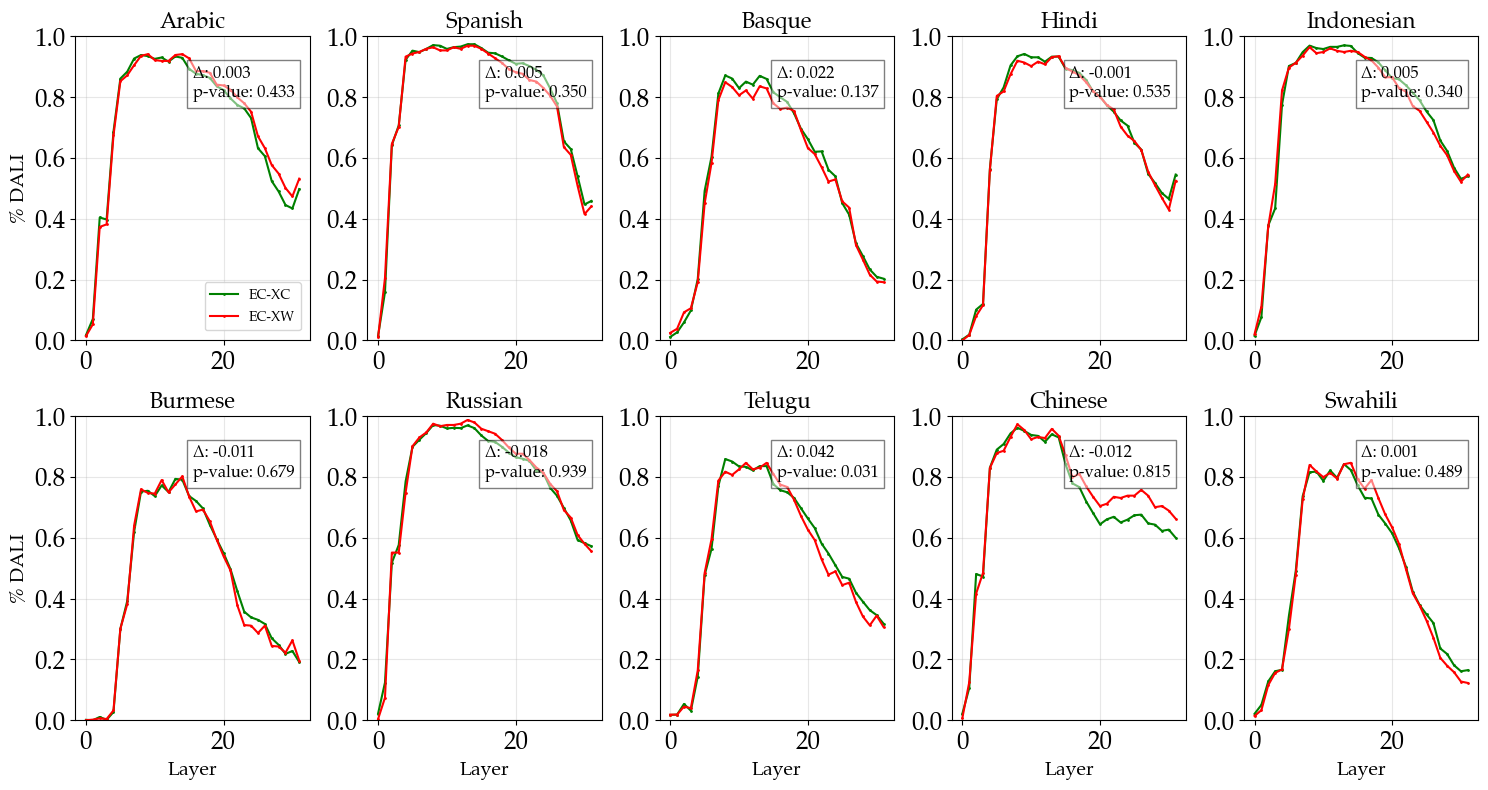

In [12]:
# Calculate accuracies for each language
from statsmodels.stats.weightstats import ztest

accuracies = {lang: (sum(acc_dict[lang])/len(acc_dict[lang])) * 100 for lang in LANGUAGE}

# Create a figure with subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Flatten axes for easier iteration
axes = axes.flatten()

for idx, (lang, ax) in enumerate(zip(LANGUAGE, axes)):
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    # Get accuracy data for this language
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==0]
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))
    incorrect_eng_correct_lang_ids = list(set(incorrect_id_eng) & set(correct_id_lang))
    incorrect_eng_incorrect_lang_ids = list(set(incorrect_id_eng) & set(incorrect_id_lang))

    
    # Get DAS data for this language
    lang_DAS = plot_DALI('xstorycloze', lang, 'Llama3.1', mode='DALI')
    lang_DAS = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}
                

    # Calculate averages for both cases
    all_list = defaultdict(list)
    cc_list = defaultdict(list)
    cw_list = defaultdict(list)
    wc_list = defaultdict(list)
    ww_list = defaultdict(list)

    for item in range(1511):
        for layer in range(32):
            all_list[layer].append(lang_DAS[item][layer])

    for item in correct_eng_correct_lang_ids:
        for layer in range(32):
            cc_list[layer].append(lang_DAS[item][layer])

    for item in correct_eng_incorrect_lang_ids:
        for layer in range(32):
            cw_list[layer].append(lang_DAS[item][layer])

    for item in incorrect_eng_correct_lang_ids:
        for layer in range(32):
            wc_list[layer].append(lang_DAS[item][layer])

    for item in incorrect_eng_incorrect_lang_ids:
        for layer in range(32):
            ww_list[layer].append(lang_DAS[item][layer])
    
        
    all_mean = []
    cc_mean = []
    cw_mean = []
    ww_mean = []
    wc_mean = []

    for k,v in all_list.items():
        all_mean.append(np.mean(v))

    for k,v in cc_list.items():
        cc_mean.append(np.mean(v))

    for k,v in cw_list.items():
        cw_mean.append(np.mean(v))

    for k,v in ww_list.items():
        ww_mean.append(np.mean(v))

    for k,v in wc_list.items():
        wc_mean.append(np.mean(v))

    
    max_idx = np.argmax(all_mean)
    count = [np.sum(cc_list[max_idx]), np.sum(cw_list[max_idx])]
    nobs = [len(cc_list[max_idx]), len(cw_list[max_idx])]
    stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
    annotation_text = f'Δ: {cc_mean[max_idx]-cw_mean[max_idx]:.3f}\np-value: {pval:.3f}'
    ax.annotate(annotation_text, xy=(0.5, 0.8), xycoords='axes fraction', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.5))



    # Plot lines for this language
    layers = list(range(32))
    ax.plot(layers, [cc_mean[l] for l in layers], 
            label='EC-XC', marker='o', color='green', markersize=1)
    ax.plot(layers, [cw_mean[l] for l in layers], 
            label='EC-XW', color = 'red', marker='o', markersize=1)
    #ax.plot(layers, [ww_mean[l] for l in layers], 
    #        label='WW', color = 'teal', marker='o', markersize=1)
    #ax.plot(layers, [wc_mean[l] for l in layers], 
    #        label='WC', color = 'magenta', marker='o', markersize=1)
    
    
    ax.set_ylim(0,1)
   
    
    # Add title with accuracy
    ax.set_title(f'{lang.capitalize()}', size=16)
    ax.grid(True, alpha=0.3)
    #ax.axvspan(8, 20, color='lightblue', alpha=0.5)
    
    # Only add x and y labels for the bottom row and leftmost column
    if idx >= 5:  # Bottom row
        ax.set_xlabel('Layer', size=14)
     
    if idx % 5 == 0:  # Leftmost column
        ax.set_ylabel('% DALI', size=14)
       
    
    # Add legend only for the first subplot
    if idx == 0:
        ax.legend(bbox_to_anchor=(0.99, 0.01), loc='lower right')


plt.tight_layout()
plt.savefig(fname='../../../../Images_DALI/xstorycloze_plots/DALItrajectory_cohort')
plt.show()

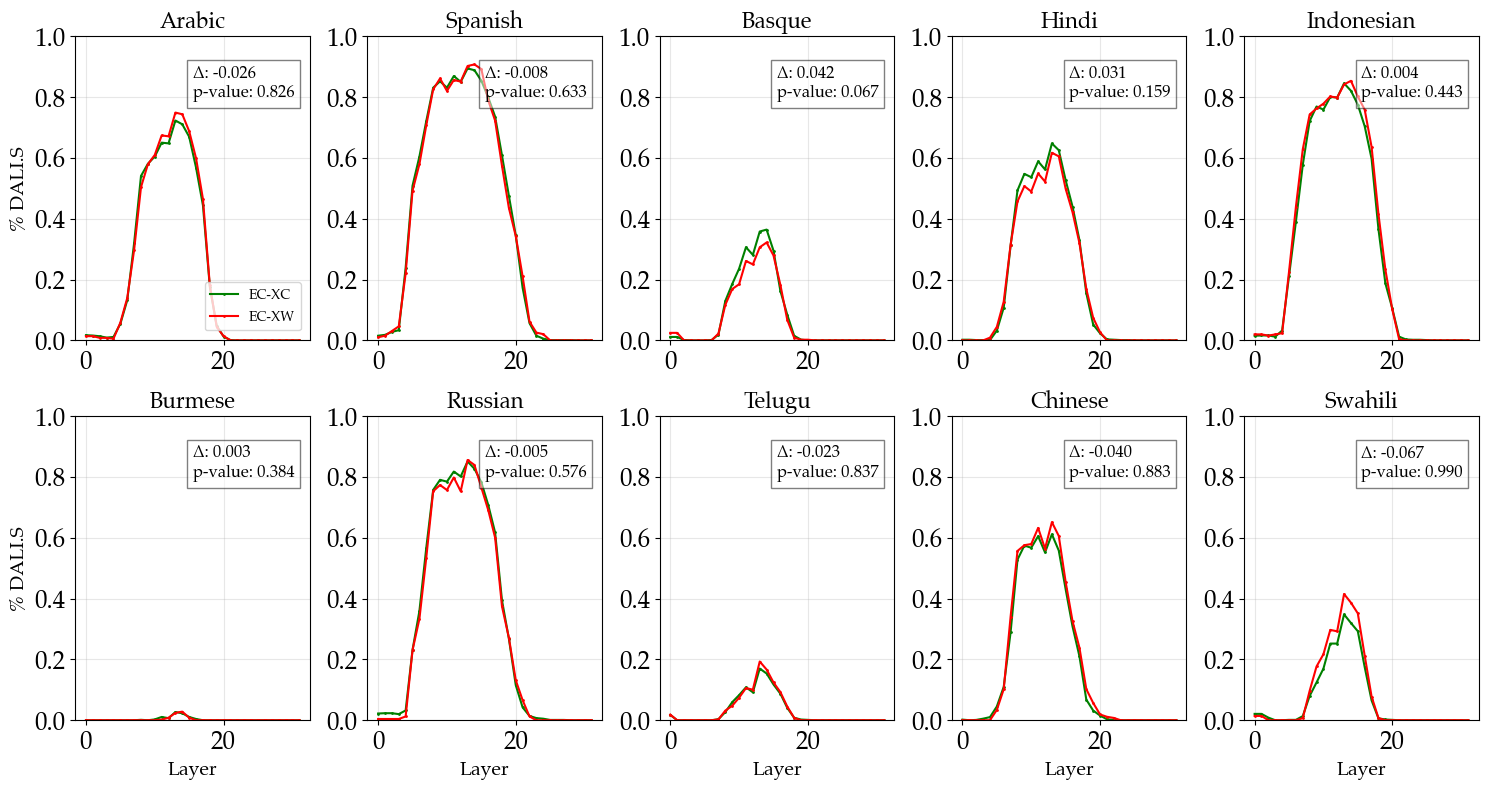

In [13]:
# Calculate accuracies for each language
from statsmodels.stats.weightstats import ztest

accuracies = {lang: (sum(acc_dict[lang])/len(acc_dict[lang])) * 100 for lang in LANGUAGE}

# Create a figure with subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Flatten axes for easier iteration
axes = axes.flatten()

for idx, (lang, ax) in enumerate(zip(LANGUAGE, axes)):
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    # Get accuracy data for this language
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==0]
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))
    incorrect_eng_correct_lang_ids = list(set(incorrect_id_eng) & set(correct_id_lang))
    incorrect_eng_incorrect_lang_ids = list(set(incorrect_id_eng) & set(incorrect_id_lang))

    
    # Get DAS data for this language
    lang_DAS = plot_DALI('xstorycloze', lang, 'Llama3.1', mode='DALIStrong')
    lang_DAS = {int(outer_k): {int(inner_k): v for inner_k, v in inner_v.items()} 
                for outer_k, inner_v in lang_DAS.items()}
                

    # Calculate averages for both cases
    all_list = defaultdict(list)
    cc_list = defaultdict(list)
    cw_list = defaultdict(list)
    wc_list = defaultdict(list)
    ww_list = defaultdict(list)

    for item in range(1511):
        for layer in range(32):
            all_list[layer].append(lang_DAS[item][layer])

    for item in correct_eng_correct_lang_ids:
        for layer in range(32):
            cc_list[layer].append(lang_DAS[item][layer])

    for item in correct_eng_incorrect_lang_ids:
        for layer in range(32):
            cw_list[layer].append(lang_DAS[item][layer])

    for item in incorrect_eng_correct_lang_ids:
        for layer in range(32):
            wc_list[layer].append(lang_DAS[item][layer])

    for item in incorrect_eng_incorrect_lang_ids:
        for layer in range(32):
            ww_list[layer].append(lang_DAS[item][layer])
    
        
    all_mean = []
    cc_mean = []
    cw_mean = []
    ww_mean = []
    wc_mean = []

    for k,v in all_list.items():
        all_mean.append(np.mean(v))

    for k,v in cc_list.items():
        cc_mean.append(np.mean(v))

    for k,v in cw_list.items():
        cw_mean.append(np.mean(v))

    for k,v in ww_list.items():
        ww_mean.append(np.mean(v))

    for k,v in wc_list.items():
        wc_mean.append(np.mean(v))

    
    max_idx = np.argmax(all_mean)
    count = [np.sum(cc_list[max_idx]), np.sum(cw_list[max_idx])]
    nobs = [len(cc_list[max_idx]), len(cw_list[max_idx])]
    stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
    annotation_text = f'Δ: {cc_mean[max_idx]-cw_mean[max_idx]:.3f}\np-value: {pval:.3f}'
    ax.annotate(annotation_text, xy=(0.5, 0.8), xycoords='axes fraction', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.5))



    # Plot lines for this language
    layers = list(range(32))
    ax.plot(layers, [cc_mean[l] for l in layers], 
            label='EC-XC', marker='o', color='green', markersize=1)
    ax.plot(layers, [cw_mean[l] for l in layers], 
            label='EC-XW', color = 'red', marker='o', markersize=1)
    #ax.plot(layers, [ww_mean[l] for l in layers], 
    #        label='WW', color = 'teal', marker='o', markersize=1)
    #ax.plot(layers, [wc_mean[l] for l in layers], 
    #        label='WC', color = 'magenta', marker='o', markersize=1)
    
    
    ax.set_ylim(0,1)
   
    
    # Add title with accuracy
    ax.set_title(f'{lang.capitalize()}', size=16)
    ax.grid(True, alpha=0.3)
    #ax.axvspan(8, 20, color='lightblue', alpha=0.5)
    
    # Only add x and y labels for the bottom row and leftmost column
    if idx >= 5:  # Bottom row
        ax.set_xlabel('Layer', size=14)
     
    if idx % 5 == 0:  # Leftmost column
        ax.set_ylabel('% DALI.S', size=14)
       
    
    # Add legend only for the first subplot
    if idx == 0:
        ax.legend(bbox_to_anchor=(0.99, 0.01), loc='lower right')


plt.tight_layout()
plt.savefig(fname='../../../../Images_DALI/xstorycloze_plots/DALIStrongtrajectory_cohort')
plt.show()

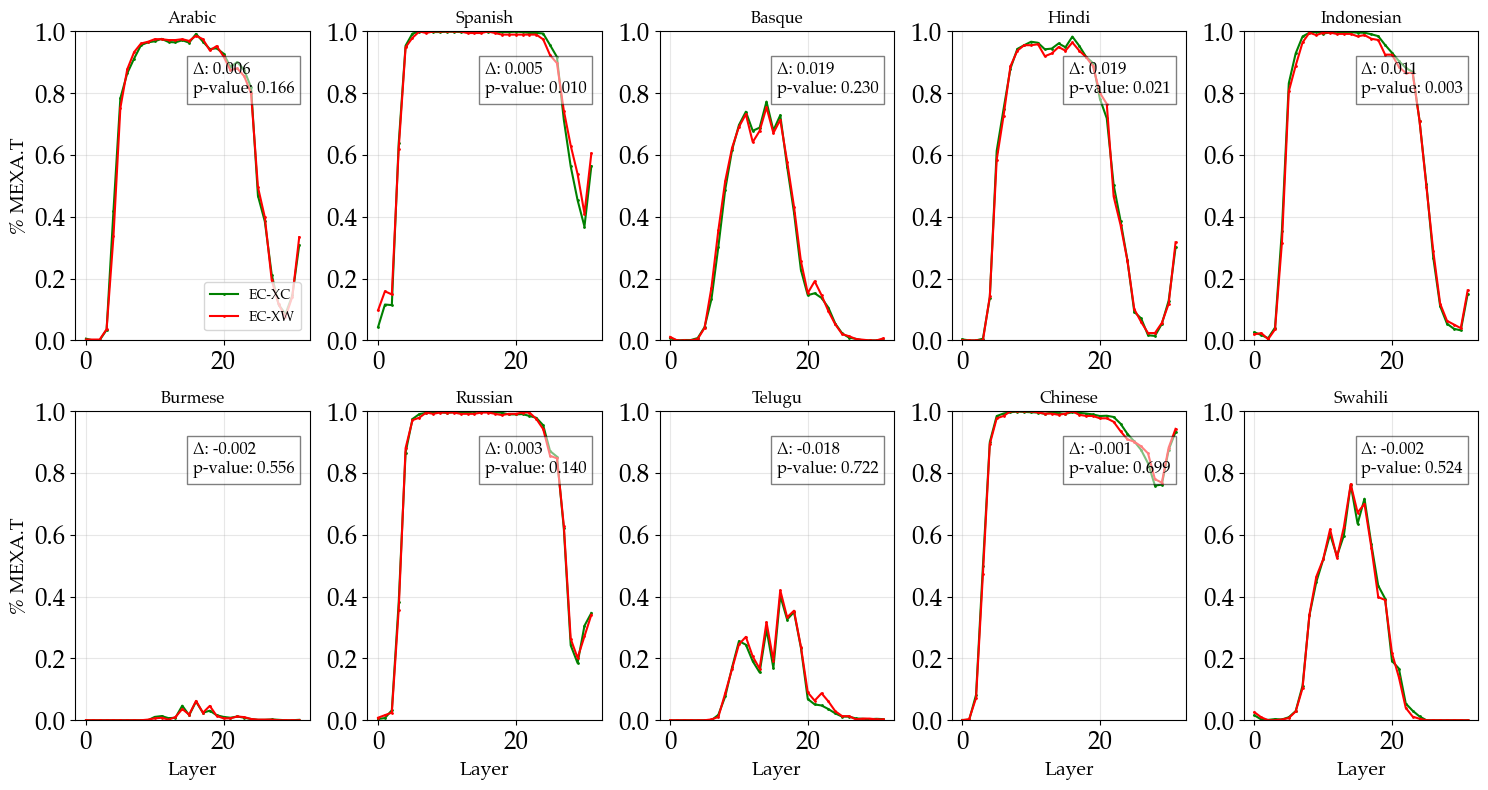

In [14]:
# Calculate accuracies for each language
from statsmodels.stats.weightstats import ztest

accuracies = {lang: (sum(acc_dict[lang])/len(acc_dict[lang])) * 100 for lang in LANGUAGE}

# Create a figure with subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Flatten axes for easier iteration
axes = axes.flatten()

for idx, (lang, ax) in enumerate(zip(LANGUAGE, axes)):
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    # Get accuracy data for this language
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==0]
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))
    incorrect_eng_correct_lang_ids = list(set(incorrect_id_eng) & set(correct_id_lang))
    incorrect_eng_incorrect_lang_ids = list(set(incorrect_id_eng) & set(incorrect_id_lang))

    
    # Get DAS data for this language
    lang_DAS = plot_DALI('xstorycloze', lang, 'Llama3.1', mode='MEXATask')
    lang_DAS = {int(k): v for k,v in lang_DAS.items()}
    lang_DAS_formatted = defaultdict(dict)
    for layer in range(32):
        for i,dali in enumerate(lang_DAS[layer]):
            lang_DAS_formatted[i][layer] = lang_DAS[layer][i]

    
    # Calculate averages for both cases
    all_list = defaultdict(list)
    cc_list = defaultdict(list)
    cw_list = defaultdict(list)
    wc_list = defaultdict(list)
    ww_list = defaultdict(list)

    for item in range(1511):
        for layer in range(32):
            all_list[layer].append(lang_DAS_formatted[item][layer])

    for item in correct_eng_correct_lang_ids:
        for layer in range(32):
            cc_list[layer].append(lang_DAS_formatted[item][layer])

    for item in correct_eng_incorrect_lang_ids:
        for layer in range(32):
            cw_list[layer].append(lang_DAS_formatted[item][layer])

    for item in incorrect_eng_correct_lang_ids:
        for layer in range(32):
            wc_list[layer].append(lang_DAS_formatted[item][layer])

    for item in incorrect_eng_incorrect_lang_ids:
        for layer in range(32):
            ww_list[layer].append(lang_DAS_formatted[item][layer])
    
        
    all_mean = []
    cc_mean = []
    cw_mean = []
    ww_mean = []
    wc_mean = []

    for k,v in all_list.items():
        all_mean.append(np.mean(v))

    for k,v in cc_list.items():
        cc_mean.append(np.mean(v))

    for k,v in cw_list.items():
        cw_mean.append(np.mean(v))

    for k,v in ww_list.items():
        ww_mean.append(np.mean(v))

    for k,v in wc_list.items():
        wc_mean.append(np.mean(v))

    
    max_idx = np.argmax(all_mean)
    
    
    count = [np.sum(cc_list[max_idx]), np.sum(cw_list[max_idx])]
    nobs = [len(cc_list[max_idx]), len(cw_list[max_idx])]
    stat, pval = smp.proportions_ztest(count, nobs, alternative="larger")
    annotation_text = f'Δ: {cc_mean[max_idx]-cw_mean[max_idx]:.3f}\np-value: {pval:.3f}'
    ax.annotate(annotation_text, xy=(0.5, 0.8), xycoords='axes fraction', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.5))



    # Plot lines for this language
    layers = list(range(32))
    ax.plot(layers, [cc_mean[l] for l in layers], 
            label='EC-XC', marker='o', color='green', markersize=1)
    ax.plot(layers, [cw_mean[l] for l in layers], 
            label='EC-XW', color = 'red', marker='o', markersize=1)
    #ax.plot(layers, [ww_mean[l] for l in layers], 
    #        label='WW', color = 'teal', marker='o', markersize=1)
    #ax.plot(layers, [wc_mean[l] for l in layers], 
    #        label='WC', color = 'magenta', marker='o', markersize=1)
    
    
    ax.set_ylim(0,1)
    
    # Add title with accuracy
    ax.set_title(f'{lang.capitalize()}')
    ax.grid(True, alpha=0.3)
    #ax.axvspan(8, 20, color='lightblue', alpha=0.5)
    
    if idx >= 5:  # Bottom row
        ax.set_xlabel('Layer', size=14)
        
    if idx % 5 == 0:  # Leftmost column
        ax.set_ylabel('% MEXA.T', size=14)
        
        
        # Add legend only for the first subplot
    if idx == 0:
        ax.legend(bbox_to_anchor=(0.99, 0.01), loc='lower right')

plt.tight_layout()
plt.savefig(fname='../../../../Images_DALI/xstorycloze_plots/MEXATasktrajectory_cohort')
plt.show()

In [ ]:
input_fields_list = ['input_sentence_1', 'input_sentence_2', 'input_sentence_3', 'input_sentence_4', 'sentence_quiz1', 'sentence_quiz2']
entoxx_sample = defaultdict(dict)
xxtoen_sample = defaultdict(dict)

for field in input_fields_list:
    entoxx, xxtoen = load_translation_sample('xstorycloze', 'Llama3.1', field)
    for lang in LANGUAGE:
        entoxx_sample[field][lang] = entoxx[lang]['scores']
        xxtoen_sample[field][lang] = xxtoen[lang]['scores']



entoxx_mean_diff = defaultdict(dict)
xxtoen_mean_diff = defaultdict(dict)

for idx, (lang, ax) in enumerate(zip(LANGUAGE, axes)):
    # Get accuracy data for this language
    correct_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==1]
    incorrect_id_eng = [i for i,acc in enumerate(acc_dict['english']) if acc==0]
    correct_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==1]
    incorrect_id_lang = [i for i,acc in enumerate(acc_dict[lang]) if acc==0]
    
    correct_eng_incorrect_lang_ids = list(set(correct_id_eng) & set(incorrect_id_lang))
    correct_eng_correct_lang_ids = list(set(correct_id_eng) & set(correct_id_lang))
    incorrect_eng_correct_lang_ids = list(set(incorrect_id_eng) & set(correct_id_lang))
    incorrect_eng_incorrect_lang_ids = list(set(incorrect_id_eng) & set(incorrect_id_lang))

    for field in input_fields_list:
        entoxx_mean_diff[lang][field] = np.mean([entoxx_sample[field][lang][i] for i in correct_eng_correct_lang_ids]) - np.mean([entoxx_sample[field][lang][i] for i in correct_eng_incorrect_lang_ids]) 
        xxtoen_mean_diff[lang][field] = np.mean([xxtoen_sample[field][lang][i] for i in correct_eng_correct_lang_ids]) - np.mean([xxtoen_sample[field][lang][i] for i in correct_eng_incorrect_lang_ids]) 


In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(entoxx_mean_diff, orient='index')

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create the heatmap
ax = sns.heatmap(df, annot=True, cmap="coolwarm", center=0, fmt=".3f", 
                linewidths=.5, cbar_kws={"shrink": .8, "label": "Δ COMET scores (En-XX)"})

# Add labels and title
#plt.title('Language Features Heatmap', fontsize=16)
#plt.ylabel('Language', fontsize=14)
plt.xlabel('Input field')

# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()

In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(xxtoen_mean_diff, orient='index')

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create the heatmap
ax = sns.heatmap(df, annot=True, cmap="coolwarm", center=0, fmt=".3f", 
                linewidths=.5, cbar_kws={"shrink": .8, "label": "Δ COMET scores (XX-En)"})

# Add labels and title
#plt.title('Language Features Heatmap', fontsize=16)
#plt.ylabel('Language', fontsize=14)
plt.xlabel('Input field')

# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()